# Charged System Search based Feature Selection

import dependencies

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import DistanceMetric
from sklearn.naive_bayes import GaussianNB
import timeit

load dataset and split into input and outputs

In [2]:
train = pd.read_csv('resources/NSLKDD_2class_preprocessed_normalized/train_nslkdd_2class_preprocessed_normalized.csv')
test = pd.read_csv('resources/NSLKDD_2class_preprocessed_normalized/test_nslkdd_2class_preprocessed_normalized.csv')

In [3]:
train.shape, test.shape

((125973, 42), (22544, 42))

In [4]:
train_y = train['41']
train_x = train.drop(['41'], axis=1)
test_y = test['41']
test_x = test.drop(['41'], axis=1)

randomly initialise position for charged particles 

In [5]:
def init_particles(x):
    return np.random.random_integers(0, 1, size=(x,41))

initialise velocity for charged particles to 0

In [6]:
def init_velocity(x):
    return np.zeros((x, 41))

calculate fitness value (charge) for each charged particles

In [7]:
def fitness(accuracy):
    charge = (accuracy - min(accuracy)) / (max(accuracy) - min(accuracy))
    return charge

In [8]:
def cv_accuracy(particles):
    epsilon = 1e-6
    accuracy = []
    for particle in particles:
        X = train_x.ix[:, np.nonzero(particle)[0]]
        clf = LogisticRegression(n_jobs=4)
        cv = cross_val_score(clf, X, train_y, cv=3, scoring='accuracy')
        accuracy.append(cv.mean())
    return np.array(accuracy)

calculates distance between each CP

In [9]:
def distance(CP, charge, num_bestCP):
    dist = DistanceMetric.get_metric("hamming")
    good_CP = np.argsort(charge)[-num_bestCP:]
    pair_dist = dist.pairwise(CP)
    a = np.array
    d = []
    for i in good_CP:
        a = np.logical_and(CP[i], CP).astype(int)
        a = np.vstack((CP[good_CP[0]], a))
        denom = dist.pairwise(a)[0, 1:]
        num = pair_dist[i]
        d.append(num/(denom+0.01))
    return np.array(d)

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
num_CP = 10
num_itr = 20
num_bestCP = 5
num_worstCP = 1
k_e = 0.1
CM_accuracy = 0
CP = init_particles(num_CP)
v = init_velocity(num_CP)

accuracy_matrix = []
features_matrix = []

for itr in range(num_itr):
    start = timeit.default_timer()
    accuracy = cv_accuracy(CP)
    max_accuracy = np.amax(accuracy)
    max_CP = CP[np.argmax(accuracy),:]
    accuracy_matrix.append(accuracy)
    features_matrix.append([np.count_nonzero(f) for f in CP])
    if max_accuracy > CM_accuracy:
        CM_accuracy = max_accuracy
        CM = np.copy(max_CP)
    print(max_accuracy, np.count_nonzero(max_CP))
    print(CM_accuracy, np.count_nonzero(CM))
    charge = fitness(accuracy)
    dist = distance(CP, charge, num_bestCP)
    best_charge = np.sort(charge)[-num_bestCP:]
    force_out = best_charge / np.square(dist.T)
    force_in = best_charge.T * dist.T
    np.place(force_out, force_out==np.inf, 0.0)
    np.place(force_in, force_in==np.inf, 0.0)
    i1 = np.zeros((num_CP,num_bestCP))
    i2 = np.zeros((num_CP,num_bestCP))
    i1[dist.T<1] = 1
    i2[dist.T>1] = 1
    best_CP = CP[np.argsort(charge)[-num_bestCP:]]
    diff = []
    for cp in best_CP:
        diff.append(cp - CP)
    diff = np.array(diff)
    force = (i1*force_in) + (i2*force_out)
    x = []
    for i in range(num_bestCP):
        x.append(force.T[i].reshape(-1,1) * diff[i])
    x = np.array(x)
    acceleration = charge.reshape(-1,1) * np.sum(x, axis = 0)
    v = (np.random.random() * v) + acceleration
    CP[sigmoid(v)>0.5] = 1
    CP[sigmoid(v)<=0.5] = 0
    CP[np.argsort(charge)[:num_worstCP]] = init_particles(num_worstCP)
    if itr%2 == 0:
        num_bestCP-=1
    end = timeit.default_timer()
    print(i," execution time: ", end - start)

0.941662111437 19
0.941662111437 19
4  execution time:  19.44396137800004
0.948957325872 19
0.948957325872 19
3  execution time:  18.762732631000063
0.956824083981 25
0.956824083981 25
3  execution time:  20.842998340999998
0.956887587573 26
0.956887587573 26
3  execution time:  20.901755396
0.957181298659 24
0.957181298659 24
3  execution time:  22.642982450999966
0.957181299604 25
0.957181299604 25
3  execution time:  21.543589371000053
0.957181299604 25
0.957181299604 25
3  execution time:  24.161016775000007


In [113]:
np.nonzero(CM)

(array([ 0,  1,  5,  6,  7,  8, 10, 11, 13, 14, 16, 19, 22, 23, 25, 28, 29,
        30, 31, 33, 34, 35, 36, 37, 39, 40]),)

In [114]:
high = np.nonzero(CM)[0]

In [115]:
log_reg = LogisticRegression()
log_reg.fit(train_x.ix[:,high], train_y)
pred = log_reg.predict(test_x.ix[:,high])
from sklearn.metrics import accuracy_score, confusion_matrix
print(accuracy_score(test_y, pred))
print(str(confusion_matrix(test_y, pred)))

0.734386089425
[[9071  640]
 [5348 7485]]


In [65]:
features_matrix = np.array(features_matrix)

In [66]:
accuracy_matrix[0], features_matrix[0]

(array([ 0.93038193,  0.94344027,  0.93495432,  0.93552587,  0.91208432,
         0.93955056,  0.93393823,  0.92525383,  0.94725854,  0.93011995,
         0.93620062,  0.93885992,  0.9258095 ,  0.92249134,  0.90968699,
         0.94780628,  0.91444198,  0.91826027,  0.929858  ,  0.95098157,
         0.94444843,  0.93846301,  0.9372723 ,  0.95546666,  0.91822057,
         0.93228708,  0.8956205 ,  0.9424083 ,  0.95278354,  0.92944521,
         0.92564281,  0.93569256,  0.94684576,  0.93709765,  0.93053274,
         0.92067348,  0.94250355,  0.93213625,  0.94620277,  0.9299215 ,
         0.94796505,  0.92261834,  0.95390281,  0.9382328 ,  0.94013798,
         0.94486121,  0.93051686,  0.91460869,  0.95365675,  0.93344607,
         0.93928066,  0.92827829,  0.93472411,  0.9057417 ,  0.92391227,
         0.93643083,  0.95118001,  0.94992579,  0.93818518,  0.92954046,
         0.90768656,  0.90072476,  0.92953254,  0.94682988,  0.91637891,
         0.92849262,  0.92279298,  0.94744112,  0.9

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

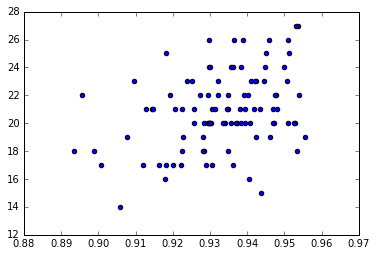

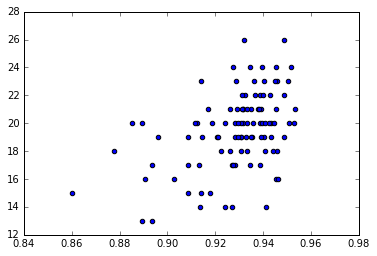

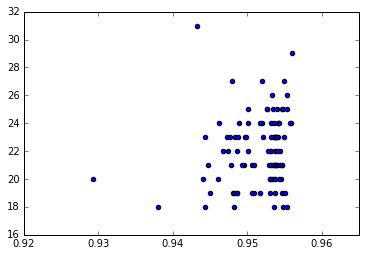

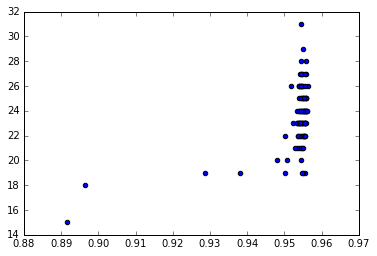

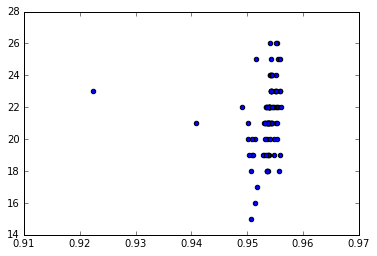

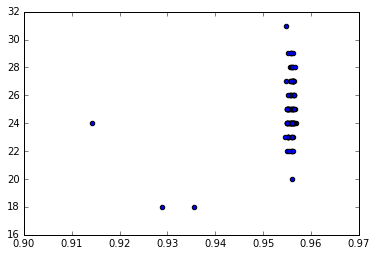

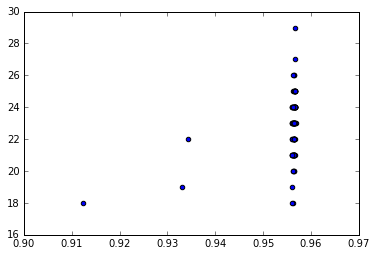

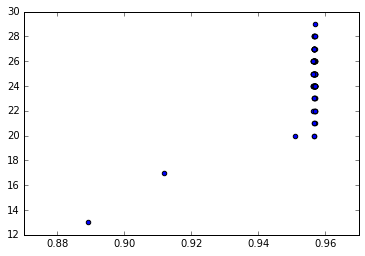

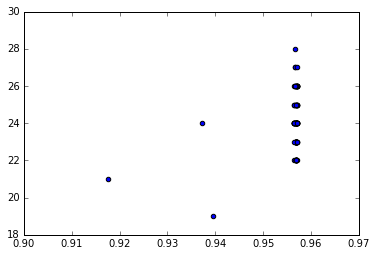

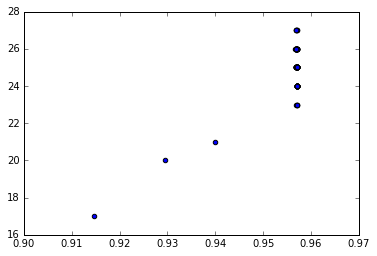

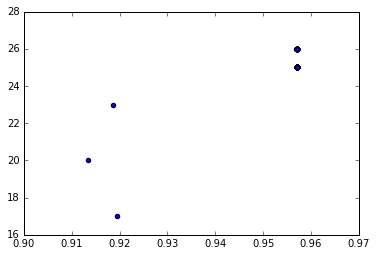

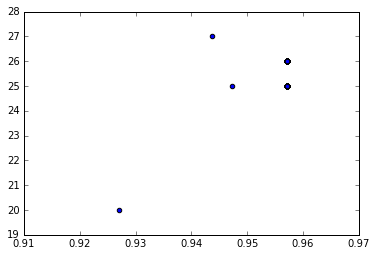

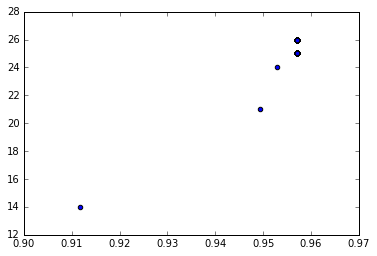

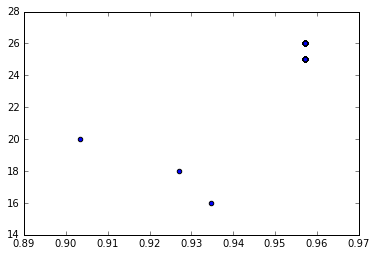

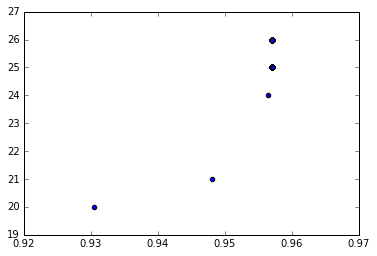

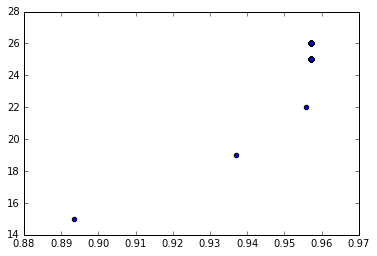

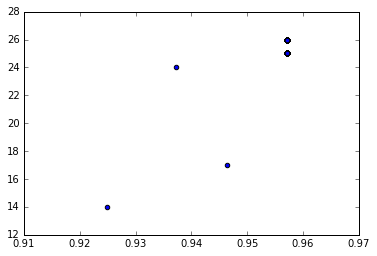

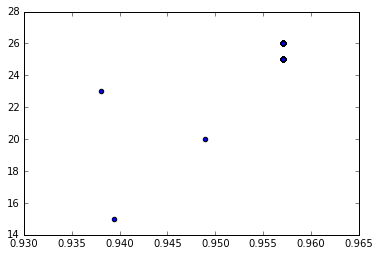

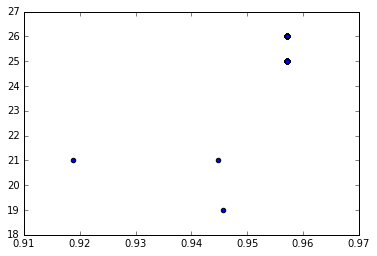

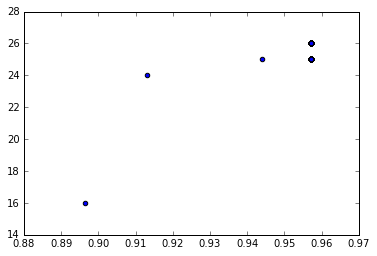

In [68]:
for i in range(num_itr):
    plt.figure()
    plt.scatter(accuracy_matrix[i], features_matrix[i])
    plt.show()